<center> <h1> IMDB Reviews Sentiment Analysis

**Introduction**

This notebook presents the development of a **lightweight, production-ready sentiment analysis pipeline** built on IMDb movie reviews. The objective is to classify text as positive or negative using traditional NLP and machine learning techniques—**no deep learning or embeddings**, to keep the solution interpretable and easy to deploy.

The project begins with a brief exploratory data analysis to understand class balance, review length, and basic patterns. In Part 2, multiple **text preprocessing techniques** are demonstrated—from basic cleaning to more advanced steps like contraction expansion and punctuation handling—both to improve model performance and highlight their individual impact for educational purposes.

A custom `TextPreprocessor` class, fully compatible with Scikit-Learn pipelines, is created to make preprocessing modular, configurable, and production-friendly. Several machine learning models are evaluated through cross-validation. Among them, **Logistic Regression** consistently delivers the best results when paired with tuned preprocessing and model hyperparameters—achieving a final accuracy of **91.67%**.

The final model is saved as a complete Scikit-Learn pipeline, ready for reuse.

**Deployment-Ready**

This project is designed with deployment in mind. The full pipeline can be served using:

* A **Flask-based web application** with a clean interface for inference
* A **Dockerized version** of the app for containerized deployment on any platform
* A published preprocessing module (`hoomanmltk`) installable via PyPI or GitHub, making it easy to reuse the core text cleaning component in any project

All deployment options and setup instructions are available in the project repository:
**[https://github.com/Hoom4n/SentiMDB](https://github.com/Hoom4n/SentiMDB)**

This is a full end-to-end solution—from raw text to a Dockerized web app—built entirely on classical NLP and machine learning.

## Part 1: Data Preparation & Quick EDA

### 1.1. Imports

In [2]:
# Core Libraries
import re
import string
import time
import warnings
import logging
import os

#from optuna.exceptions import TrialPruned
from sklearn.metrics import f1_score, accuracy_score

# Data Handling
import numpy as np
import pandas as pd
import optuna

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import learning_curve
import seaborn as sns

# Text Processing
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.corpus import stopwords

# Scikit-learn Utilities
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_validate, StratifiedKFold, cross_val_predict, cross_val_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Parallel Processing
from joblib import Parallel, delayed

In [ ]:
# Download necessary NLTK resources
import nltk

nltk.download('punkt')
nltk.download('vader_lexicon')  
nltk.download('stopwords') 
nltk.download('wordnet')  
nltk.download('punkt_tab')

In [ ]:
# Loading DataSet from Kaggle

import kagglehub


path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

imdb_df = pd.read_csv(os.path.join(path, "IMDB Dataset.csv"))

### 1.2. Quick EDA

In [5]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [3]:
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Average Reviews word count: 231.15694



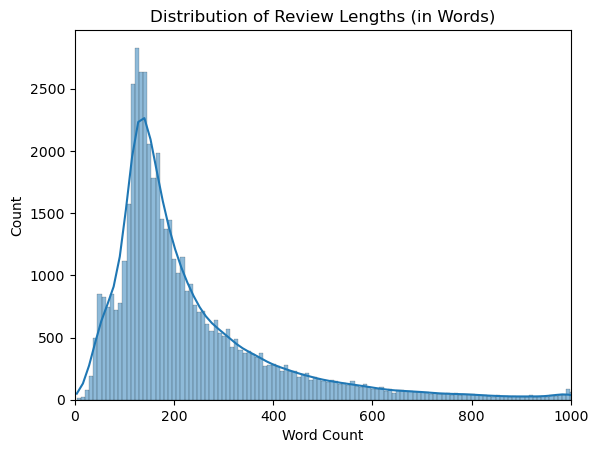

In [12]:
# Distribution of Review Lengths (in Words)

imdb_df['word_count'] = imdb_df['review'].apply(lambda x: len(x.split()))
print(f"Average Reviews word count: {imdb_df['word_count'].mean()}\n")
sns.histplot(imdb_df['word_count'] , kde=True)
plt.xlabel("Word Count")
plt.title("Distribution of Review Lengths (in Words)")
plt.xlim(0,1000)
plt.show()

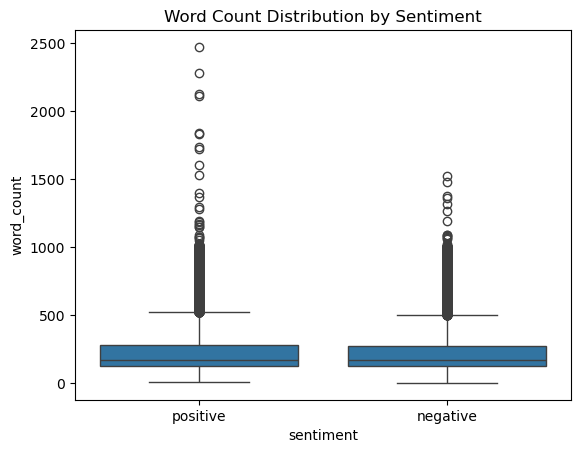

In [29]:
# Word Count Distribution vs Sentiment

sns.boxplot(x='sentiment', y='word_count', data=imdb_df)
plt.title("Word Count Distribution by Sentiment")
plt.show()

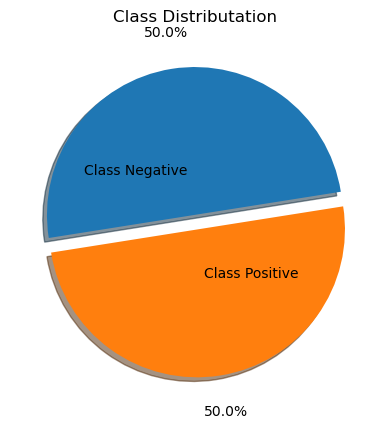

In [13]:
# Target Distributation Inspection

def target_pie(y, y_encoded=True):
    if not y_encoded:
        y = LabelEncoder().fit_transform(y)
    plt.pie([sum(y==0), sum(y==1)], labels=["Class Negative" , "Class Positive"] , autopct='%1.1f%%', labeldistance=.3,
           pctdistance=1.25, explode=(0,0.1), shadow=True, startangle=9)
    plt.title("Class Distributation")
    plt.show()

target_pie(imdb_df.iloc[:,1], y_encoded=False)

In [19]:
# Check for not acceptable target values

imdb_df.iloc[:,1].unique()

array(['positive', 'negative'], dtype=object)

In [16]:
# Prinitng a sample

print(imdb_df.iloc[0,0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

**Data Analysis**

- The dataset consists of 50,000 movie reviews collected from the IMDb website, with two polarities: Negative & Postive.
- Balanced Target Classes: The dataset contains roughly equal numbers of positive and negative reviews, so stratified sampling for the test set is not necessary.
- On average, each review contains approximately 230 words. However, the exact number will be determined after preprocessing steps such as removing markdown tags. Most reviews tend to be around 180 words in length.
- No significant difference in word count was observed between positive and negative reviews.

In [3]:
# Since classes are equally distibuted, I'll shuffle them and pick 0.15 of data as Test Set

X_train, X_test, y_train, y_test = train_test_split(imdb_df["review"], imdb_df["sentiment"], test_size=0.15, shuffle=True, random_state=42)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

## Part 2: Exploring Text Preprocessing Techniques

### 2.1. Text Cleaning

Text cleaning steps are necessary to prepare raw text for analysis or machine learning by eliminating unwanted characters and inconsistencies.

**Removing HTML/Markdown Tags**
HTML or Markdown tags (e.g., `<br>`, `**`) are formatting elements that do not provide meaningful information for sentiment analysis. Removing

**Removing Special Characters, Punctuation, and Digits**
Special characters and punctuation marks (e.g., `!`, `@`, `#`) usually don't carry significant sentiment information. Digits (e.g., "2025", "123") may also be irrelevant in some contexts. Removing them ensures the focus remains on the words.

**Removing Extra Whitespace**
Extra spaces, tabs, or line breaks can distort the text and cause issues in tokenization. Removing unnecessary whitespace ensures uniformity and cleaner data for further processing.

**Lowercasing**
Converting all text to lowercase ensures that words like "Movie" and "movie" are treated as the same, which helps reduce redundancy and improves the model's performance.
Here’s a polished version of your note in a more formal, robot-generated tone:

**<i>Note:** It is possible to replace numbers or URLs with a constant, such as `NUMBER`, to reduce noise. Raw digits themselves can introduce noise, as machine learning algorithms may learn that specific numbers (e.g., the digit "6") frequently appear in negative reviews, which could lead to misclassification in future predictions. By replacing numbers or URLs, we remove this noise while preserving the information that these elements represent a number or a URL. This approach has been implemented in the `TextProcessor` transformer class.

In [29]:
# TrainSet sample text

text = X_train[6] + "www.example.url"
text

'If it wasn\'t for some immature gullible idiot I know insisting that I watch this "documentary" I would never have seen this comedy! This film is full of bad scripting and laughable moments. One in particular is where the Afghan police / soldiers arrest Don Larson for filming in the streets while they allow the cameraman to carry on filming his arrest and then drive away, still filming, presumably to his plush hotel. Then there\'s the scene where a car crashes into another car which has been turned upside down and parked nicely on the side of the road without any evidence of it being in a crash or explosion.<br /><br />I am surprised this has currently got the rating it has (5.8 / 10). I thought IMDb users had more sense.www.example.url'

In [30]:
# removing markdowns

text = re.sub(r'<[^>]+>|#+\s|\*\*?|-{2,}', ' ', text)
text

'If it wasn\'t for some immature gullible idiot I know insisting that I watch this "documentary" I would never have seen this comedy! This film is full of bad scripting and laughable moments. One in particular is where the Afghan police / soldiers arrest Don Larson for filming in the streets while they allow the cameraman to carry on filming his arrest and then drive away, still filming, presumably to his plush hotel. Then there\'s the scene where a car crashes into another car which has been turned upside down and parked nicely on the side of the road without any evidence of it being in a crash or explosion.  I am surprised this has currently got the rating it has (5.8 / 10). I thought IMDb users had more sense.www.example.url'

In [31]:
# removing urls

text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
text

'If it wasn\'t for some immature gullible idiot I know insisting that I watch this "documentary" I would never have seen this comedy! This film is full of bad scripting and laughable moments. One in particular is where the Afghan police / soldiers arrest Don Larson for filming in the streets while they allow the cameraman to carry on filming his arrest and then drive away, still filming, presumably to his plush hotel. Then there\'s the scene where a car crashes into another car which has been turned upside down and parked nicely on the side of the road without any evidence of it being in a crash or explosion.  I am surprised this has currently got the rating it has (5.8 / 10). I thought IMDb users had more sense. '

In [32]:
# remove punctuations

text = text.translate(str.maketrans('', '', string.punctuation))
text

'If it wasnt for some immature gullible idiot I know insisting that I watch this documentary I would never have seen this comedy This film is full of bad scripting and laughable moments One in particular is where the Afghan police  soldiers arrest Don Larson for filming in the streets while they allow the cameraman to carry on filming his arrest and then drive away still filming presumably to his plush hotel Then theres the scene where a car crashes into another car which has been turned upside down and parked nicely on the side of the road without any evidence of it being in a crash or explosion  I am surprised this has currently got the rating it has 58  10 I thought IMDb users had more sense '

In [33]:
# remove numbers

text = re.sub(r'\d+', '', text)
text

'If it wasnt for some immature gullible idiot I know insisting that I watch this documentary I would never have seen this comedy This film is full of bad scripting and laughable moments One in particular is where the Afghan police  soldiers arrest Don Larson for filming in the streets while they allow the cameraman to carry on filming his arrest and then drive away still filming presumably to his plush hotel Then theres the scene where a car crashes into another car which has been turned upside down and parked nicely on the side of the road without any evidence of it being in a crash or explosion  I am surprised this has currently got the rating it has    I thought IMDb users had more sense '

In [34]:
# lower casing

text = text.lower()
print(text)

if it wasnt for some immature gullible idiot i know insisting that i watch this documentary i would never have seen this comedy this film is full of bad scripting and laughable moments one in particular is where the afghan police  soldiers arrest don larson for filming in the streets while they allow the cameraman to carry on filming his arrest and then drive away still filming presumably to his plush hotel then theres the scene where a car crashes into another car which has been turned upside down and parked nicely on the side of the road without any evidence of it being in a crash or explosion  i am surprised this has currently got the rating it has    i thought imdb users had more sense 


### 2.2. Text Normalization

Text normalization is the process of transforming text into a standard, consistent format. It's often used to make text data more uniform and easier to analyze.

**Expanding Contractions**

Converts contractions like *"don't"* to *"do not"*, or *"it's"* to *"it is"*. This helps in preserving semantic meaning and improves model understanding. I will use `contractions` class to apply this step

In [ ]:
# Expand Contractions

text = "I can't believe it's already over I've never seen anything like it"
print(f"== Original Text: ==\n{text}")
text = contractions.fix(text)
print(f"\n== Expand Contractions: ==\n{text}")

== Original Text: ==
I can't believe it's already over I've never seen anything like it

== Expand Contractions: ==
I cannot believe it is already over I have never seen anything like it


**Spell Checking**

Corrects common typos or misspellings to ensure consistency (e.g., *"amazng"* → *"amazing"*), especially useful in user-generated content like reviews.
While it enhances token quality and model robustness, it’s computationally expensive and may introduce errors by misinterpreting context, requiring careful consideration in the processing pipeline.

In [ ]:
# spell checking

text = "I cheaded overr there and misinterpret him. reviewers  dont this befur"
print(f"== Original Text: ==\n{text}")
txtblob = TextBlob(text)
text = txtblob.correct().string
print(f"\n== Expand Contractions: ==\n{text}")

== Original Text: ==
I cheaded overr there and misinterpret him. reviewers  dont this befur

== Expand Contractions: ==
I headed over there and misinterpret him. reviews  dont this before


**Stemming**

- Stemming is the process of reducing words to their root or base form by removing suffixes. The goal of stemming is to normalize words, making different forms of a word (such as plurals, tenses, or derivations) appear as a single word. (for example: "Running" → "Run" , "Happiness" → "Happi" , "Easily" → "Eas")
- Stemming helps to reduce the dimensionality of the text data, making it easier for machine learning algorithms to process. By mapping different forms of a word to the same root form, we ensure that the model treats them as the same concept, which can improve accuracy and performance

**How Stemming Works**

Stemming algorithms typically use a set of predefined rules to chop off word endings. These rules are based on common patterns in language. For example, a common stemming algorithm (like Porter Stemmer) might remove:

 - "ing" from verbs (e.g., "playing" → "play")
 - "ly" from adjectives/adverbs (e.g., "quickly" → "quick")
 - "es" from plural nouns (e.g., "boxes" → "box").

**Limitations of Stemming**

- Over-stemming: The process can sometimes remove too much, leading to incorrect roots. For instance, "happiness" becomes "happi", which may not be useful or meaningful in context.
- Loss of Meaning: Unlike lemmatization, which takes context into account to find the proper base form, stemming often results in stems that are not real words, which can reduce interpretability.

In [ ]:
# stemming

words = "Running jumped playing wanted better enjoying explored studies trying studied goes walking healthier larger running".split()

stemmer = PorterStemmer()

stemmed_tokens = {word : stemmer.stem(word) for word in words}

print(stemmed_tokens)

{'Running': 'run', 'jumped': 'jump', 'playing': 'play', 'wanted': 'want', 'better': 'better', 'enjoying': 'enjoy', 'explored': 'explor', 'studies': 'studi', 'trying': 'tri', 'studied': 'studi', 'goes': 'goe', 'walking': 'walk', 'healthier': 'healthier', 'larger': 'larger', 'running': 'run'}


**Lemmatization**

- Lemmatization is the process of reducing a word to its base or dictionary form, known as a lemma. Unlike stemming (which just chops off word endings), lemmatization uses vocabulary and morphological analysis to return a proper word that actually appears in the language. (for example running, ran, runs to run, better to good)
- Improves the quality of text analysis (e.g., in search engines or NLP) and also helps with tasks like text classification, sentiment analysis, and topic modeling by standardizing words.

**How It Works:**
- Part-of-speech tagging: Determines the role of the word (verb, noun, etc.).
- Dictionary lookup: Matches the word with its root form in a lexicon.

**Limitations**
- Lemmatization is context-sensitive, meaning it may struggle with ambiguous words.
- It requires a dictionary or lexical resource, limiting its coverage.
- The process can be computationally expensive and may lose nuanced information.

In [ ]:
# lemmatize

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = {token : lemmatizer.lemmatize(token) for token in words}

print(lemmatized_tokens)

{'Running': 'Running', 'jumped': 'jumped', 'playing': 'playing', 'wanted': 'wanted', 'better': 'better', 'enjoying': 'enjoying', 'explored': 'explored', 'studies': 'study', 'trying': 'trying', 'studied': 'studied', 'goes': 'go', 'walking': 'walking', 'healthier': 'healthier', 'larger': 'larger', 'running': 'running'}


**Stopword Removal**

Stopwords are common words that occur frequently in a language but carry little to no meaningful information for text analysis. Examples include "the," "is," "in," "on," "and," "of," etc.

In [ ]:
# NLTK stopwords

print(" , ".join(stopwords.words('english')[:100]))

a , about , above , after , again , against , ain , all , am , an , and , any , are , aren , aren't , as , at , be , because , been , before , being , below , between , both , but , by , can , couldn , couldn't , d , did , didn , didn't , do , does , doesn , doesn't , doing , don , don't , down , during , each , few , for , from , further , had , hadn , hadn't , has , hasn , hasn't , have , haven , haven't , having , he , he'd , he'll , her , here , hers , herself , he's , him , himself , his , how , i , i'd , if , i'll , i'm , in , into , is , isn , isn't , it , it'd , it'll , it's , its , itself , i've , just , ll , m , ma , me , mightn , mightn't , more , most , mustn , mustn't , my , myself


### 2.3. Tokenization

Tokenization is the process of splitting text into smaller units, called tokens, such as words, sentences, or subwords, to facilitate further text analysis or processing in NLP.

**Methods**:

1. **Word Tokenization**

   * **Definition**: Splits text into individual words.
   * **Example**: "I love NLP!" → \['I', 'love', 'NLP']

2. **Sentence Tokenization**

   * **Definition**: Splits text into sentences.
   * **Example**: "I love NLP. It's amazing." → \['I love NLP.', 'It's amazing.']

3. **Subword Tokenization**

   * **Definition**: Breaks words into smaller meaningful units or subwords.
   * **Example**: "unhappiness" → \['un', 'happi', 'ness']

4. **Whitespace-based Tokenization**

   * **Definition**: Splits text based on spaces.
   * **Example**: "Hello World!" → \['Hello', 'World!']

5. **Regex-based Tokenization**

   * **Definition**: Uses regular expressions to define splitting rules.
   * **Example**: "It's a well-known fact." → \['It', "'", 's', 'a', 'well-known', 'fact']

In [35]:
# tokenize

tokens = word_tokenize(text)
print(tokens)

['if', 'it', 'wasnt', 'for', 'some', 'immature', 'gullible', 'idiot', 'i', 'know', 'insisting', 'that', 'i', 'watch', 'this', 'documentary', 'i', 'would', 'never', 'have', 'seen', 'this', 'comedy', 'this', 'film', 'is', 'full', 'of', 'bad', 'scripting', 'and', 'laughable', 'moments', 'one', 'in', 'particular', 'is', 'where', 'the', 'afghan', 'police', 'soldiers', 'arrest', 'don', 'larson', 'for', 'filming', 'in', 'the', 'streets', 'while', 'they', 'allow', 'the', 'cameraman', 'to', 'carry', 'on', 'filming', 'his', 'arrest', 'and', 'then', 'drive', 'away', 'still', 'filming', 'presumably', 'to', 'his', 'plush', 'hotel', 'then', 'theres', 'the', 'scene', 'where', 'a', 'car', 'crashes', 'into', 'another', 'car', 'which', 'has', 'been', 'turned', 'upside', 'down', 'and', 'parked', 'nicely', 'on', 'the', 'side', 'of', 'the', 'road', 'without', 'any', 'evidence', 'of', 'it', 'being', 'in', 'a', 'crash', 'or', 'explosion', 'i', 'am', 'surprised', 'this', 'has', 'currently', 'got', 'the', 'rat

### 2.4. Vectorization

Machine learning algorithms require numeric inputs. Techniques like Bag of Words (BoW), TF-IDF, and word embeddings transform text into vectors or matrices.

#### 2.4.1. Bag of Words

As the naming suggesuts, First, you build a vocabulary (bag) of all the words in the training corpus, Then, each document (or text) is represented as a vector of word counts.
- If corpus is ["I love NLP", "NLP is amazing"], the vocabulary could be ["I", "love", "NLP", "is", "amazing"]. The corresponding vectors would be:
- "I love NLP" → [1, 1, 1, 0, 0]
- "NLP is amazing" → [0, 0, 1, 1, 1]

  
Scikit-Learn's `CountVectorizer` implements the BoW. It's important to note that the output of both `CountVectorizer` and `TfidfVectorizer` are Scipy Sparse matrices.

In [ ]:
corpus = ["I love NLP", "NLP is amazing"]
vectorizer = CountVectorizer()
vectorizer.fit_transform(corpus).toarray()

array([[0, 0, 1, 1],
       [1, 1, 0, 1]], dtype=int64)

In [ ]:
# list of features
vectorizer.get_feature_names_out()

array(['amazing', 'is', 'love', 'nlp'], dtype=object)

#### 2.4.1. TF-IDF

**TF-IDF** (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word within a document relative to a collection of documents (or corpus).

TF-IDF is composed of two parts:

1. **Term Frequency (TF)**: This measures how frequently a word appears in a document. The intuition is that the more times a word appears in a document, the more important it is for that document. It is usually calculated as:

   $$
   \text{TF}(t, d) = \frac{\text{Number of times term t appears in document d}}{\text{Total number of terms in document d}}
   $$

2. **Inverse Document Frequency (IDF)**: This measures how important a word is across all documents in the corpus. Words that are common across many documents (like "the" or "and") are not useful in **distinguishing documents**. IDF reduces the weight of such words. It is calculated as:

   $$
   \text{IDF}(t) = \log \left( \frac{\text{Total number of documents}}{\text{Number of documents containing term t}} \right)
   $$

   The idea is that terms that appear in many documents have a lower IDF, while terms that appear in fewer documents have a higher IDF.

3. **TF-IDF**: The final score for a word in a document is the product of its TF and IDF values:

   $$
   \text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
   $$

   This gives a weight to each word in the document based on its frequency in the document and its rarity in the entire corpus.




**Example:**

Consider the following three documents:

1. "I love machine learning"
2. "Machine learning is fun"
3. "I love fun things"

**Step 1: Create the vocabulary**
The vocabulary (unique words) from all three documents is:
`["I", "love", "machine", "learning", "is", "fun", "things"]`

**Step 2: Calculate Term Frequency (TF)**
For each document, count how often each word appears, then divide by the total number of words in that document.

For example, in the first document ("I love machine learning"):

* TF("I") = 1/4
* TF("love") = 1/4
* TF("machine") = 1/4
* TF("learning") = 1/4

**Step 3: Calculate Inverse Document Frequency (IDF)**
IDF is calculated for each word based on how many documents it appears in. The formula is:

$$
\text{IDF}(t) = \log \left( \frac{\text{Total documents}}{\text{Documents containing the term}} \right)
$$

For example, the word "machine" appears in 2 out of 3 documents, so:

$$
\text{IDF}(\text{machine}) = \log \left( \frac{3}{2} \right)
$$

**Step 4: Calculate TF-IDF**
Multiply the TF and IDF for each term in each document. For example:

$$
\text{TF-IDF}(\text{machine}, \text{Doc1}) = \text{TF}(\text{machine}, \text{Doc1}) \times \text{IDF}(\text{machine})
$$

**Step 5: Create the final TF-IDF matrix**
Each document is now represented by a vector of TF-IDF values for each term in the vocabulary, creating a matrix where each row represents a document and each column represents a word from the vocabulary.

In [ ]:
corpus = ["I love machine learning", "Machine learning is fun", "I love fun things"]
tfidf = TfidfVectorizer()

print(tfidf.fit_transform(corpus).toarray())

[[0.         0.         0.57735027 0.57735027 0.57735027 0.        ]
 [0.45985353 0.60465213 0.45985353 0.         0.45985353 0.        ]
 [0.51785612 0.         0.         0.51785612 0.         0.68091856]]


In [ ]:
tfidf.vocabulary_

{'love': 3, 'machine': 4, 'learning': 2, 'is': 1, 'fun': 0, 'things': 5}

## Part 3: Model Development and Optimization

### 3.1. Preprocessing Pipelines

- The `TextPreprocessor` is a flexible and efficient transformer class designed to encapsulate all the text preprocessing steps outlined in the previous section. It integrates seamlessly into Scikit-learn pipelines and offers customizable tuning through its arguments. Input validation has been incorporated to ensure that the transformer only accepts iterable objects, consistent with the behavior of vectorizers.

- To enhance performance, the class utilizes Joblib for **parallel processing**, which accelerates text preprocessing by leveraging multiple CPU cores and threads. Additionally, a logging mechanism has been implemented to issue warnings in the event of a preprocessing failure, ensuring the pipeline continues running smoothly without interruption.

- By default, the class outputs text, as subsequent vectorizers that include built-in tokenization will handle tokenization later in the pipeline. However, it also offers the flexibility to output tokens if needed.

In [ ]:
# Text Processor

# Logger for warning and error messages
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.WARNING)



class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    A flexible and efficient transformer for cleaning tasks such as URL removal, 
    contraction expansion, punctuation removal, spell checking, stemming, lemmatization, 
    and more. It supports parallel processing for faster transformations on large datasets.

    Parameters:
    ----------
    url_remove : bool, default=True
        If True, removes URLs from the text.

    numbers : {"remove", "replace", "leave_them_be", None}, default="remove"
        Specifies how to handle numbers (remove, replace with "NUMBER", or leave unchanged).

    expand_contractions : bool, default=False
        If True, expands contractions like "don't" to "do not".

    spell_checking : bool, default=False
        If True, applies spell correction using TextBlob.

    stemming : bool, default=False
        If True, applies Porter Stemming.

    lemmatize : bool, default=False
        If True, applies WordNet Lemmatization.

    markdown_remove : bool, default=True
        If True, removes markdown formatting from the text.

    remove_punctuation : bool, default=True
        If True, removes punctuation characters from the text.

    output_mode : {"text", "tokens"}, default="text"
        If "text", outputs preprocessed text; if "tokens", outputs tokenized words.

    n_jobs : int, default=1
        Number of jobs for parallel processing (set >1 for multi-core).

    raise_errors : bool, default=False
        If True, raises errors during processing; if False, logs a warning.

    Methods:
    -------
    fit(X, y=None) : Fit the transformer to the input data.
    transform(X) : Preprocess the text data.
    """
    
    def __init__(self, url_remove=True, numbers="remove", expand_contractions=False, spell_checking=False,
                 stemming=False, lemmatize=False, markdown_remove=True, remove_punctuation=True, output_mode="text", 
                 n_jobs=1, raise_errors=False):
        # Initialize the preprocessing parameters
        self.url_remove = url_remove
        if numbers not in ["remove", "replace", "leave_them_be", None]:
            raise ValueError("numbers must be 'remove', 'replace', 'leave_them_be' or None")
        self.numbers = numbers
        self.stemming = stemming
        self.lemmatize = lemmatize
        self.markdown_remove = markdown_remove
        self.remove_punctuation = remove_punctuation
        self.expand_contractions = expand_contractions
        self.spell_checking = spell_checking
        if output_mode not in ["text", "tokens"]:
            raise ValueError("output_mode must be 'text' or 'tokens'")
        self.output_mode = output_mode
        self.n_jobs = n_jobs
        self.raise_errors = raise_errors

        # Initialize tools for stemming and lemmatization
        self.lemmatizer_ = WordNetLemmatizer() if lemmatize else None
        self.stemmer_ = PorterStemmer() if stemming else None

        # Define regex patterns for URL and markdown removal
        self._url_pattern = re.compile(
            r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*'
        ) if url_remove else None
        
        self._markdown_pattern = re.compile(
            r'(\#{1,6}\s*)|(\*{1,2})|(__)|(\~\~)|`{1,3}|!\[.*?\]\(.*?\)|\[.*?\]\(.*?\)|<.*?>'
        ) if markdown_remove else None

    def fit(self, X, y=None):
        # Validate input and prepare the transformer
        self._validate_input(X)
        self.n_features_in_ = 1
        return self

    def transform(self, X):
        # Ensure the transformer is fitted and preprocess the input data
        check_is_fitted(self)
        X = self._validate_input(X)
        
        # Apply preprocessing in parallel if multiple jobs are specified
        if self.n_jobs == 1:
            return np.array([self._preprocess_text(text) for text in X], dtype=object)
        else:
            return np.array(Parallel(n_jobs=self.n_jobs)(
                delayed(self._preprocess_text)(text) for text in X), dtype=object)

    def _validate_input(self, X):
        # Validate and preprocess the input (DataFrame, Series, ndarray, or list)
        if isinstance(X, pd.DataFrame):
            if X.shape[1] != 1:
                raise ValueError("DataFrame must have exactly one column")
            return X.squeeze().astype(str).tolist()
        elif isinstance(X, (pd.Series, np.ndarray)):
            return pd.Series(X).astype(str).tolist()
        elif isinstance(X, list):
            return [str(x) for x in X]
        else:
            raise ValueError(f"Unsupported input type: {type(X)}")

    def _preprocess_text(self, text):
        try:
            # Perform various text preprocessing steps
            if self.markdown_remove:
                text = self._markdown_pattern.sub(' ', text)
            if self.url_remove:
                text = self._url_pattern.sub(' ', text)
            if self.expand_contractions:
                text = contractions.fix(text)
            text = text.lower() 
            if self.remove_punctuation:
                text = text.translate(str.maketrans('', '', string.punctuation)) 
            tokens = word_tokenize(text)  

            # Apply spell checking if enabled
            if self.spell_checking:
                tokens = [TextBlob(token).correct().string for token in tokens]
            
            # Handle numbers based on the specified mode
            if self.numbers == "remove":
                tokens = [t for t in tokens if not re.search(r'\d', t)]
            elif self.numbers == "replace":
                tokens = ["NUMBER" if re.search(r'\d', t) else t for t in tokens]
            
            # Apply stemming or lemmatization
            if self.stemming and self.lemmatize:
                raise ValueError("Both Stemming & Lemmatizing cannot be applied at the same time!")
            if self.stemming:
                tokens = [self.stemmer_.stem(t) for t in tokens]
            elif self.lemmatize:
                tokens = [self.lemmatizer_.lemmatize(t) for t in tokens]

            # Return processed text or tokens based on output_mode
            return ' '.join(tokens) if self.output_mode == "text" else tokens

        except Exception as e:
            # Handle errors by logging a warning or raising an error
            if self.raise_errors:
                raise
            else:
                logger.warning(f"Error processing text: {str(e)}")
                return "" if self.output_mode == "text" else []

    def get_feature_names_out(self, input_features=None):
        # Return the name of the processed text feature
        return np.array(['processed_text'])


In [5]:
# Function to convert elements of the input to float32
# Note: This will convert a sparse matrix to dense, which can be memory-intensive for large datasets

def convert_to_float32(X):
    return X.astype(np.float32)

# FunctionTransformerapplies the convert_to_float32 function
float32convertor = FunctionTransformer(convert_to_float32, validate=False)

### 3.2. Baseline Establishment

In [ ]:
# List of model configurations: each tuple contains a model class, model hyperparameters, and any additional transformers
model_configs = [
    (LogisticRegression, {"random_state": 42, "n_jobs": -1}, []),
    (RandomForestClassifier, {"random_state": 42, "n_jobs": -1}, []),
    (KNeighborsClassifier, {"n_jobs": -1}, []),
    (LGBMClassifier, {"random_state": 42, "n_jobs": -1, "verbose": -1}, [float32convertor]), # LGBM requires a float32/64 convertion
    (XGBClassifier, {"random_state": 42, "n_jobs": -1}, []),
    (AdaBoostClassifier, {"random_state": 42}, []),
    (LinearSVC, {"random_state": 42}, []),
    (MultinomialNB, {}, []),  ]


# Function to benchmark multiple models, evaluate using cross-validation, and store results
def benchmark_models(model_configs, X, y, cv_count=5, scoring="f1"):
    
    # Creating pipelines for each model. Each pipeline includes: TextPreprocessor, CountVectorizer, Any additional transformers 
    pipelines = [(model.__name__, make_pipeline(TextPreprocessor(n_jobs=-1), CountVectorizer(),
                                                *extras, model(**params))) for model, params, extras in model_configs]
    
    results = []  # Store the results for each model
    kcv = StratifiedKFold(n_splits=cv_count, shuffle=True, random_state=42)  # Stratified k-fold for cross-validation
    # Format the metric label to display it properly
    metric_label = scoring.replace('_', ' ').title()
    # Initialize a progress bar for tracking model evaluation progress
    progress_bar = tqdm(pipelines, desc="Evaluating models", unit="model")
    # Iterate through each model and its pipeline
    for name, pipe in progress_bar:
        progress_bar.set_postfix_str(name)  
        try:
            start_time = time()  
            
            # unlike cross_validate_score, cross_validate can return a train score as well
            scores = cross_validate(pipe, X, y, cv=kcv, scoring=scoring, n_jobs=-1, return_train_score=True, error_score="raise")
            
            runtime = time() - start_time
            results.append({
                "Model": name,
                f"Train {metric_label}": scores["train_score"].mean(),  
                f"CV {metric_label}": scores["test_score"].mean(),  #
                f"CV {metric_label} STD": scores["test_score"].std(),  
                "Runtime (s)": f"{runtime:.1f}"
            })

        except Exception as e:
            # If an error occurs during the evaluation of a model, log a warning and mark it as failed
            warnings.warn(f"\nModel {name} failed: {str(e)}", category=UserWarning)
            results.append({
                "Model": name,
                f"Train {metric_label}": "FAILED", 
                f"CV {metric_label}": "FAILED", 
                f"CV {metric_label} STD": "FAILED",
                "Runtime (s)": "N/A"  # No runtime since the model failed
            })

    results_df = pd.DataFrame(results)

    # If the cross-validation column contains valid numbers, sort the models by the score
    if results_df[sort_col].dtype == 'float64':
        return results_df.sort_values(f"CV {metric_label}", ascending=False).reset_index(drop=True)  # Sort by the metric and reset index
    
    return results_df.reset_index(drop=True)  # Return the results without sorting if one of evaluations failed

results = benchmark_models(model_configs, X=X_train, y=y_train, cv_count=5, scoring="f1")
results

Evaluating models: 100%|██████████| 8/8 [16:46<00:00, 125.78s/model, MultinomialNB]         


,Model,Train F1,CV F1,CV F1 STD,Runtime (s)
0,LogisticRegression,0.974079,0.885690,0.002817,93.4
1,LinearSVC,0.999988,0.869542,0.002235,96.6
2,LGBMClassifier,0.896871,0.860718,0.001084,97.3
3,XGBClassifier,0.935447,0.860142,0.001935,107.5
4,RandomForestClassifier,1.000000,0.847550,0.000990,195.4
5,MultinomialNB,0.898916,0.843079,0.002726,90.8
6,AdaBoostClassifier,0.809510,0.806884,0.006110,114.4
7,KNeighborsClassifier,0.780701,0.662799,0.003233,210.8


These are 5-fold cross-validation results for a set of classifiers. I included a diverse range of predictors—from simple linear models to tree-based boosting and bagging algorithms, as well as Naive Bayes and KNN.

**Analysis of Results**

- Logistic Regression outperforms the other classifiers but shows signs of overfitting, despite having a reasonable runtime compared to others.
- Tree-based boosting models follow, with LightGBM standing out as both faster and better-generalized than XGBoost or Logistic Regression. Despite the curse of dimensionality, Logistic Regression often performs well in high-dimensional, sparse feature spaces, which is typical in text data.
- KNN yields the worst performance, which is expected, as it relies on distance metrics and suffers significantly in high-dimensional spaces where data points become increasingly distant and less informative.
- Based on this evaluation, I will proceed with Logistic Regression for further tuning and optimization.

### 3.3. Error Analysis

#### 3.3.1. Performance Metrics & Confusion Matrix

==== TrainSet CV5 Out-of-Sample Classification Metrics ====
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     21292
           1       0.88      0.89      0.89     21208

    accuracy                           0.89     42500
   macro avg       0.89      0.89      0.89     42500
weighted avg       0.89      0.89      0.89     42500



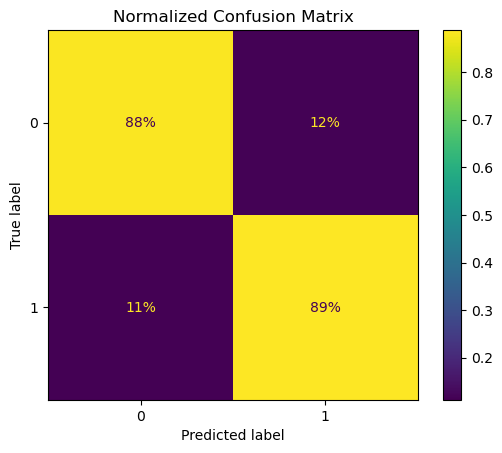

In [ ]:
def clfeval(predictor, X,y,cv=5,train_report=False, conf_mtx=False):
    kcv = StratifiedKFold(n_splits=cv,shuffle=True,random_state=42)
    yhat_oos = cross_val_predict(predictor, X, y, cv=kcv, n_jobs=-1)
    if train_report:
        yhat = predictor.fit(X,y).predict(X)
        print(f"==== TrainSet Classification Metrics ====")
        print(classification_report(y, yhat),"\n")
    print(f"==== TrainSet CV5 Out-of-Sample Classification Metrics ====")
    print(classification_report(y, yhat_oos))
    if conf_mtx:
        ConfusionMatrixDisplay.from_predictions(y, yhat_oos,normalize="true", values_format=".0%")
        plt.title("Normalized Confusion Matrix")
        plt.show()

logr = make_pipeline(preprocessing, LogisticRegression(random_state=42, n_jobs=-1))
clfeval(logr, X_train,y_train,cv=5,train_report=False, conf_mtx=True)

**Results Analysis**

- The results are based on an out-of-sample evaluation using Scikit-learn's `cross_val_predict`
- Accuracy and F-score are identical, as expected due to the perfectly balanced target class distribution.
- Precision and recall for both the positive and negative classes are nearly identical.
- The number of false positives and false negatives is very similar, indicating that both classes have an equal level of detection error.

#### 3.3.2. Analysis of Misclassified Samples

In [ ]:
# Get Out-of-Sample predictions from Logistic Regression

logr = make_pipeline(preprocessing, LogisticRegression(n_jobs=-1,random_state=42)).fit(X_train,y_train)
yhat_oos = cross_val_predict(logr, X_train, y_train, cv=5, n_jobs=-1)

In [ ]:
# Priniting some false positives

false_positives = X_train[(y_train == 0) & (yhat_oos == 1)]

for i in [13,25,632]:
    print(f"==sample== \n:{false_positives.iloc[i]}")

==sample== 
:Although Charlie Chaplin made some great short comedies in the late 1910's, others don't quite make it. Examples like His New Job and Shanghaied come to mind, and I would also The Floorwalker in this category.<br /><br />Charlie gets mistaken for a manager of a department store (and vice versa). This manager tries to steal money from the cash register and make a run for it, and Charlie is just an honest costumer but getting blamed for some missing objects, stolen by other costumers.<br /><br />There aren't many laughs in it, except for the last couple of minutes or so with some great scenes on the escalator. For the rest, quite disappointing.<br /><br />4/10.
==sample== 
:I understand there was some conflict between Leigh and the great Maggie Smith during the filming. Understandable when you put one of the world's greatest actresses of all time (Smith, of course) with one whose performances seem to get worse with each subsequent film.
==sample== 
:A combat veteran, fresh f

**Analysis**

- Sample 1: Opens with positive praise but quickly turns negative, ending with "4/10". The shift isn’t recognized well by the model.
- Sample 2: Positive comments about one actress clash with the negative review of another, but the model might be swayed by the first part.
- Sample 3: Mix of harsh criticism ("ridiculous dialogue") and humor ("good laughs"), with a sarcastic tone. The positive ending misleads sentiment.

All samples contain mixed sentiment, with shifts from positive to negative, and irony/sarcasm.

**Suggestions**

- Negation Handling: Implement a method to detect negations (e.g., "not good") to adjust sentiment appropriately. I plan to experiment with expanding contractions and using bigrams for better context understanding.

- Rating Extraction: Numerical ratings (e.g., "4/10") often carry strong sentiment cues. However, since I have removed whole numbers, explicit handling of such ratings is not feasible.

- Sentiment Shift Awareness: To capture sentiment changes within a sentence or paragraph, more advanced techniques like Deep Learning would be required to detect and manage sentiment shifts accurately.

- Sarcasm Detection: Identifying sarcasm in reviews is challenging. Specialized models, potentially leveraging Deep Learning and sarcasm detection techniques, would be necessary to handle this effectively.



In [ ]:
# Priniting some false negatives

false_negatives = X_train[(y_train == 1) & (yhat_oos == 0)]

for i in [131,257,63]:
    print(f"==sample== \n:{false_negatives.iloc[i]}")

==sample== 
:Considering all the teen films like "the Breakfast Club" and "Pretty In Pink" that are lionized. It is surprising that this one is so ignored.<br /><br />There is no sex in it, but sex is thought of, including the idea that it may matter what others think about it. The kids do not always get along with their parents, but neither the parents or the kids are seen as always right or wrong, and the parents are not seen as monsters.<br /><br />It deals with hero-worship. How one girl does a dangerous thing, which could have lead to real dustier, before realizing that she was wrong.<br /><br />The movie is kind of ahead of its' time. One kid asks another kid what birth control she uses. She says she is doing nothing to need birth control. She replies (wrongly) "oral sex".
==sample== 
:Great cult flick for MST-3K types: Richard Boone is a mess -- bad hair, arthritis, even his dark glasses aren't right; about as good as a bad dino-flick can get... actually, that charging saber-too

**Analysis**
- Sample 1: Despite discussing themes of teen angst, sex, and hero-worship, the sentiment is largely neutral to negative in tone. It discusses problematic teenage behaviors but is not overly positive.
- Sample 2: Although it acknowledges the film’s low quality (bad acting, hair, etc.), the humor and cult appeal of the movie are positive ("pretty cool" dinosaur), which could be missed by models focusing solely on negative cues.
- Sample 3: The review expresses appreciation for the movie’s depth, photography, and acting, but it contains critical comments about the movie’s slow pace. The mix of appreciation and criticism might be misclassified.
- In all three samples, the overall sentiment is mixed, with both positive and negative aspects, but key positive points (e.g., "ahead of its time", "pretty cool", "grips") may be underweighted by the model.

**Suggestion**
- Improve Mixed Sentiment Detection: Implement more sophisticated Deep Learning methods (such as BERT) to better handle and detect mixed sentiments in reviews.

- Sarcasm Detection: Use specialized Deep Learning techniques, potentially including sarcasm detection models, to accurately identify and address sarcasm in reviews.

- Contextual Embeddings: Leverage advanced models like BERT to capture the context of words within a sentence, improving overall sentiment analysis accuracy by understanding nuanced meanings.

#### 3.3.3. Learning Curve

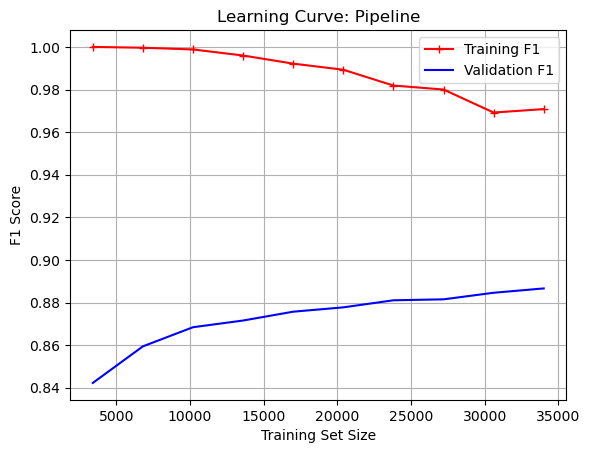

In [ ]:
def learning_curve_plot(predictor, X, y, cv=5, scoring="f1", exploit_incremental_learning=False):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    train_sizes, train_scores, valid_scores = learning_curve(predictor, X, y,train_sizes=np.linspace(0.1, 1.0, 10),
        cv=skf, scoring=scoring, n_jobs=-1, exploit_incremental_learning=exploit_incremental_learning)

    plt.plot(train_sizes, train_scores.mean(axis=1), "r-+", label="Training F1")
    plt.plot(train_sizes, valid_scores.mean(axis=1), "b-", label="Validation F1")
    plt.title(f"Learning Curve: {predictor.__class__.__name__}")
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid()
    plt.show()
    return train_sizes, train_scores, valid_scores

train_sizes, train_scores, valid_scores = learning_curve_plot(logr, X_train,y_train, cv=5, scoring="f1", exploit_incremental_learning=False)

This plot clearly indicates overfitting: there's a noticeable gap between the final training and validation performance, and the gap narrows as more data is added—a classic sign of overfitting. While adding more data is one of the best ways to address overfitting, it's unfortunately not an option in our project.

What we can do, however, is constrain the Logistic Regression model using regularization techniques. This will be applied in hyperparameter tuning. Although this may result in a slight drop in training performance, it is expected to significantly improve generalization to unseen data.

#### 3.3.4. Word Importance

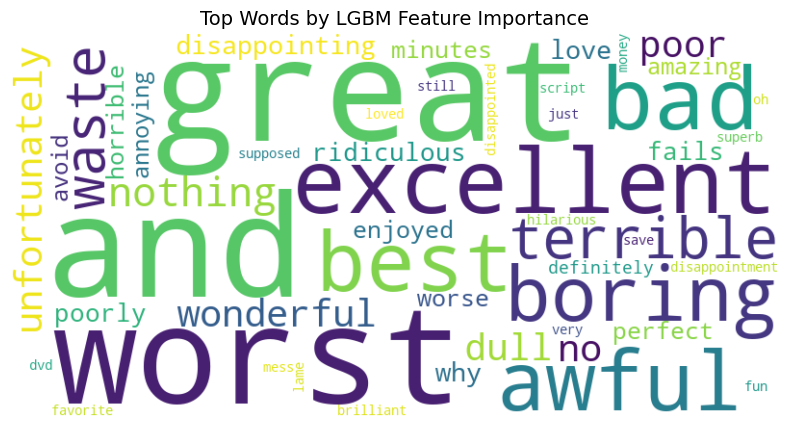

In [ ]:
# using LGBM since it supports feature importance
lgbm = make_pipeline(preprocessing,float32convertor,LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1)).fit(X_train,y_train)

word_importance = dict(zip(lgbm.named_steps["pipeline"].named_steps["countvectorizer"].get_feature_names_out()
                            , lgbm.named_steps["lgbmclassifier"].booster_.feature_importance()))

top_n = 50
word_importance = dict(sorted(word_importance.items(), key=lambda x: x[1], reverse=True)[:top_n])

wordcloud = WordCloud(width=800,height=400,background_color='white',colormap='viridis', min_font_size=10,max_font_size=150,
    random_state=42).generate_from_frequencies(word_importance)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Words by LGBM Feature Importance', fontsize=14)
plt.show()

The size of each word reflects its feature importance as determined by the **LGBM** algorithm. Adjectives such as *"great"*, *"worst"*, and *"excellent"* are examples of *sentiment words* or *opinion words*, which play a crucial role in distinguishing between the two classes of data.

An interesting observation is the importance of the stop word 'and,' which does not convey sentiment. To address this, I will use TF-IDF and remove stopwords

### 3.4. Fine-Tuning Sentiment Analysis Pipeline

In this section, I will aim to improve the predictive performance of the outperforming pipeline by tweaking various text preprocessing steps and tuning the hyperparameters of the logistic regression model to maximize performance while controlling overfitting.


#### 3.4.1. Fine-Tuning Text Preprocessing Pipeline with Optuna

In the baseline establishment step, I compared several classification models using default settings for both preprocessing and model parameters. The basic preprocessing included lowercasing the text and removing numbers, markdown tags, and punctuation that don’t meaningfully contribute to sentiment.

In the next phase, I will try a few additional techniques to improve performance:

* **Stemming**: This reduces words to their base or root form (e.g., “running” becomes “run”).
* **Different vectorization methods**: I’ll test both CountVectorizer and TF-IDF. TF-IDF helps reduce the influence of very common words that don’t help distinguish between texts.
* **Bigrams**: Instead of looking at individual words, I’ll also consider pairs of consecutive words. For example, in the sentence *"This movie is not funny,"* the bigram *"not funny"* can help preserve the negative sentiment, which a simple bag-of-words model might miss.
* **Removing stop words**: These are common words like “the” or “is” that usually don’t add much meaning. I’ll test whether removing them improves results.
* **Max features**: I’ll limit the vocabulary to the top N most frequent terms, ignoring less relevant ones.
* **min\_df and max\_df**: These help filter out very rare or overly common words by setting thresholds based on how often a word appears across documents.

I’ve also enabled contraction expansion by default to help with handling negations, based on Error Analysis insights.

All these steps and their possible configurations create a large search space, making an exhaustive grid search impractical. So instead, I’ll use **Optuna**, a hyperparameter optimization library based on Bayesian methods. It searches more efficiently by learning from past trials.

To speed things up even further, I’m using Optuna’s pruner, which stops poor-performing trials early. The optimization process is run using 3-fold cross-validation on a subset of 25,000 samples to balance thoroughness and efficiency.


In [ ]:
def objective(trial):
    # Defining seach space
    use_stem=trial.suggest_categorical("stemmed",[True,False])
    X_sub= X_train_stem if use_stem else X_train_nostem
    vec_type=trial.suggest_categorical("vectorizer",["count","tfidf"])
    ngram=trial.suggest_categorical("ngram_range",[(1,1),(1,2)])
    stop=trial.suggest_categorical("stop_words",[None,"english"])
    max_feat=trial.suggest_int("max_features",1000,50000,log=True)
    min_df=trial.suggest_categorical("min_df",[2,5,10])
    max_df=trial.suggest_categorical("max_df",[0.75,0.85,0.9,1.0])

    # vectorizer specific settings
    if vec_type=="count":
        vec=CountVectorizer(ngram_range=ngram,stop_words=stop,
                            max_features=max_feat,min_df=min_df,max_df=max_df)
    else:
        vec=TfidfVectorizer(ngram_range=ngram,stop_words=stop,
                            max_features=max_feat,min_df=min_df,max_df=max_df)

    pipe=Pipeline([("vect",vec),("clf",LogisticRegression(random_state=42,n_jobs=-1))])

    skf=StratifiedKFold(n_splits=3,shuffle=True,random_state=42)
    scores=[]

    # a custom cross-validation to integrate Optuna pruner
    for fold,(tr_idx,val_idx) in enumerate(skf.split(X_sub,y_sub)):
        pipe.fit(X_sub[tr_idx],y_sub[tr_idx])
        preds=pipe.predict(X_sub[val_idx])
        score=f1_score(y_sub[val_idx],preds)
        trial.report(score,fold)
        if trial.should_prune():
            raise TrialPruned()
        scores.append(score)
    return sum(scores)/len(scores)

In [ ]:
%%time
# sampling 25K of data, stratifed
X_sub, _, y_sub, _ = train_test_split(X_train, y_train, train_size=25000, stratify=y_train, random_state=42)
X_sub, y_sub = pd.DataFrame(X_sub).reset_index(drop=True), pd.Series(y_sub).reset_index(drop=True)

# to avoid stemming whole train data in each search combo, i'll fed trials a stemmed and non stemmed data
X_train_stem = TextPreprocessor(n_jobs=-1, expand_contractions=True, stemming=True).fit_transform(X_sub)
X_train_nostem = TextPreprocessor(n_jobs=-1, expand_contractions=True, stemming=False).fit_transform(X_sub)

study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(),pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=150)

[I 2025-05-09 15:01:25,886] A new study created in memory with name: no-name-af014447-cecd-4eb7-8019-8e22cb245f10
\\?\C:\Users\ASUS\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
\\?\C:\Users\ASUS\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  warnings.warn(message)
[I 2025-05-09 15:01:59,180] Trial 0 finished with value: 0.8947107370132352 and parameters: {'stemmed': True, 'vectorizer': 'tfidf', 'ngram_range': (1, 2), 'stop_words': None, 'max_features': 24855, 'min_df': 2, 'max_df': 0.9}. Best is trial 0 with value: 0.894710737013

CPU times: total: 1h 18min 24s
Wall time: 1h 25min 34s


In [ ]:
# prinint top 5 combos

sorted_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)

top_n = 5
for trial in sorted_trials[:top_n]:
    print(f"Trial #{trial.number}: Value = {trial.value}")
    print(f"Parameters: {trial.params}")
    print("-" * 50)

Trial #100: Value = 0.8962479447128624
Parameters: {'stemmed': True, 'vectorizer': 'tfidf', 'ngram_range': (1, 2), 'stop_words': None, 'max_features': 43047, 'min_df': 5, 'max_df': 0.75}
--------------------------------------------------
Trial #98: Value = 0.896096755294416
Parameters: {'stemmed': True, 'vectorizer': 'tfidf', 'ngram_range': (1, 2), 'stop_words': None, 'max_features': 43371, 'min_df': 5, 'max_df': 0.75}
--------------------------------------------------
Trial #96: Value = 0.8960888950574208
Parameters: {'stemmed': True, 'vectorizer': 'tfidf', 'ngram_range': (1, 2), 'stop_words': None, 'max_features': 47815, 'min_df': 5, 'max_df': 0.75}
--------------------------------------------------
Trial #118: Value = 0.8960795904745709
Parameters: {'stemmed': True, 'vectorizer': 'tfidf', 'ngram_range': (1, 2), 'stop_words': None, 'max_features': 42120, 'min_df': 5, 'max_df': 0.75}
--------------------------------------------------
Trial #95: Value = 0.8960449491861566
Parameters: {

Okay. Based on the top 5 trials: stemming is useful, TF-IDF performs best, bigrams work best, and removing stopwords didn’t help. There’s only slight variation in max_features.

This seems to be due to Optuna’s behavior—it gets stuck in a narrow search space and mostly tweaks max_features, which might be leading to a suboptimal solution. I’ll take these parameters and, in the next step, tune the full logistic regression pipeline accordingly.

Now fit a Pipeline based on mentioned settings on full training data and test it

==== TrainSet CV5 Out-of-Sample Classification Metrics ====
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     21292
           1       0.90      0.91      0.90     21208

    accuracy                           0.90     42500
   macro avg       0.90      0.90      0.90     42500
weighted avg       0.90      0.90      0.90     42500



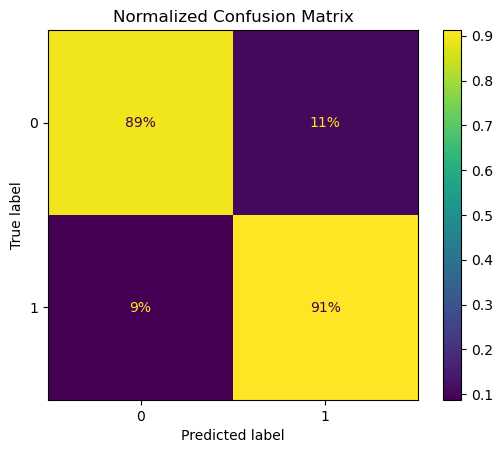

In [18]:
TUNED_TEXTPROCESSOR_PARAMS = {'expand_contractions': True, 'stemming': True, 'n_jobs': -1}
TUNED_TFIDF_PARAMS = {'ngram_range': (1, 2), 'max_features': 43047, 'min_df': 5, 'max_df': 0.75}

logr_tuned = make_pipeline(
    TextPreprocessor(**TUNED_TEXTPROCESSOR_PARAMS),
    TfidfVectorizer(**TUNED_TFIDF_PARAMS),
    LogisticRegression(random_state=42, n_jobs=-1))

clfeval(logr, X_train, y_train, conf_mtx=True)

Alright. We've achieved a 2% reduction in false negatives, a 1% decrease in false positives, and nearly a 9% reduction in overall error compared to our baseline model. Let's continue tuning.

#### 3.4.2. Fine-Tuning Logistic Regression with Optuna

As we saw in Section 3.3.3 (Learning Curve), the model is overfitted. To address this overfitting and improve performance on unseen data, I will introduce regularization and fine-tune its parameters. Below is the search space for Logistic Regression, which includes regularization hyperparameters (such as intensity and L1/L2 type), options for early stopping, and settings to ensure guaranteed convergence (by adjusting tolerance for improvement and maximum iterations in gradient descent). I will also experiment with different solvers.

These trials will use the tuned hyperparameters from the previous preprocessing step. Unlike the previous section, since these trials are relatively quick, I will apply a search over the entire training data with 150 trials.

In [13]:
def objective(trial):
    
    # defining search space
    params = {
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'tol': trial.suggest_float('tol', 1e-5, 1e-3, log=True),
        'max_iter': 5000 }

    # since liblinear only support l1 regularization, i also did not included saga as it takes LONG runtimes
    if params['penalty'] == 'l1':
        params['solver'] = trial.suggest_categorical('solver_for_l1', ['liblinear'])
    else:
        params['solver'] = trial.suggest_categorical('solver_for_l2', ['lbfgs', 'sag'])

    score = cross_val_score(LogisticRegression(**params, random_state=42, n_jobs=-1), X_prep,  y_train,
                            cv=5, scoring='accuracy',n_jobs=-1).mean()
    return score

In [14]:
%%time

tuned_prep = make_pipeline(TextPreprocessor(**TUNED_TEXTPROCESSOR_PARAMS) , TfidfVectorizer(**TUNED_TFIDF_PARAMS))

# feed Optuna with preprocessed data
X_prep = tuned_prep.fit_transform(X_train)

study_l = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler())
study_l.optimize(objective, n_trials=150)

[I 2025-05-13 13:10:00,854] A new study created in memory with name: no-name-acc7e078-c2bf-49d3-9114-763654e3ff36
[I 2025-05-13 13:10:02,309] Trial 0 finished with value: 0.5009882352941177 and parameters: {'C': 0.0004956440000058563, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced', 'tol': 1.9040234425473364e-05, 'solver_for_l1': 'liblinear'}. Best is trial 0 with value: 0.5009882352941177.
[I 2025-05-13 13:10:04,473] Trial 1 finished with value: 0.8705411764705883 and parameters: {'C': 0.444673431419333, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced', 'tol': 5.5359402862173156e-05, 'solver_for_l1': 'liblinear'}. Best is trial 1 with value: 0.8705411764705883.
[I 2025-05-13 13:10:05,609] Trial 2 finished with value: 0.6155529411764705 and parameters: {'C': 0.010322821922640427, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced', 'tol': 0.000964757218788938, 'solver_for_l1': 'liblinear'}. Best is trial 1 with value: 0.8705411764705883.
[I 202

CPU times: total: 11.6 s
Wall time: 7min 48s


In [15]:
sorted_trials = sorted(study_l.trials, key=lambda t: t.value, reverse=True)

top_n = 5
for trial in sorted_trials[:top_n]:
    print(f"Trial #{trial.number}: Value = {trial.value}")
    print(f"Parameters: {trial.params}")
    print("-" * 50)

Trial #63: Value = 0.9086117647058825
Parameters: {'C': 5.7794495513868185, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 'tol': 4.2742177892216486e-05, 'solver_for_l2': 'lbfgs'}
--------------------------------------------------
Trial #37: Value = 0.9085882352941177
Parameters: {'C': 3.7887823736934756, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'tol': 1.1899943513574165e-05, 'solver_for_l2': 'lbfgs'}
--------------------------------------------------
Trial #15: Value = 0.9085647058823529
Parameters: {'C': 5.622742965020892, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'tol': 1.4166267203466994e-05, 'solver_for_l2': 'lbfgs'}
--------------------------------------------------
Trial #131: Value = 0.9085647058823529
Parameters: {'C': 6.435462869095215, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'tol': 1.8777823017326833e-05, 'solver_for_l2': 'sag'}
--------------------------------------------------


==== TrainSet CV5 Out-of-Sample Classification Metrics ====
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     21292
           1       0.90      0.92      0.91     21208

    accuracy                           0.91     42500
   macro avg       0.91      0.91      0.91     42500
weighted avg       0.91      0.91      0.91     42500



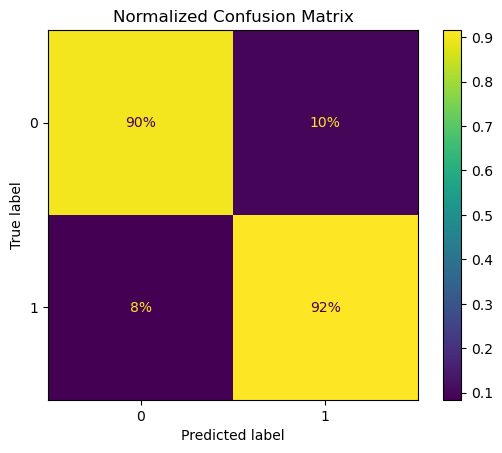

In [17]:
TUNED_TEXTPROCESSOR_PARAMS = {'expand_contractions': True, 'stemming': True, 'n_jobs': -1}
TUNED_TFIDF_PARAMS = {'ngram_range': (1, 2), 'max_features': 43047, 'min_df': 5, 'max_df': 0.75}
LOGREG_PARAMS = {'C': 5.7794495513868185, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 
                 'tol': 4.2742177892216486e-05, 'random_state':42 , 'n_jobs':-1}

logr_tuned = make_pipeline(
    TextPreprocessor(**TUNED_TEXTPROCESSOR_PARAMS),
    TfidfVectorizer(**TUNED_TFIDF_PARAMS),
    LogisticRegression(**LOGREG_PARAMS))

clfeval(logr_tuned, X_train, y_train, conf_mtx=True)

We’ve made another improvement! By fine-tuning both preprocessing and the classifier, we’ve achieved a 3% reduction in false negatives and a 2% reduction in false positives compared to our baseline model. This fine-tuning has resulted in an 18% decrease in overall error, leading to an 91% validation F1 score and accuracy.

#### 3.4.4. Sentiment Lexicon Ensembling

**Can Sentiment Lexicons Help Correct Misclassifications?**

In this section, I explore whether incorporating sentiment lexicons can help reduce misclassified samples and improve model performance.

**What Are Sentiment Lexicons?**

Before machine learning became dominant in sentiment analysis, most systems relied on rule-based approaches. These systems used predefined vocabularies—called *sentiment lexicons*—where each word was assigned a sentiment score based on its polarity (positive, negative, or neutral).

To compute the sentiment of a sentence or paragraph, the scores of individual words were summed, and the overall score determined the sentiment polarity of the text. While this approach was limited in nuance and flexibility, it formed the foundation for modern sentiment analysis.


**VADER**

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a widely used rule-based sentiment analysis tool designed specifically for social media text. It is lexicon-based and provides four scores: *positive*, *neutral*, *negative*, and *compound* (a normalized aggregate score). VADER is known for its ability to handle emoticons, slang, and negation.


**How We Can Integrate Sentiment Lexicons to Improve Model Performance?**

I examined two ways to integrate VADER scores into the current modeling pipeline:

1. **Adding VADER as a Feature**

My first approach was to include VADER’s compound score as an additional feature. I built a parallel pipeline that extracted this score and then combined it with the main feature set using `FeatureUnion`.

However, this approach reduced performance, lowering accuracy to 0.83. I deliberately excluded the individual *positive*, *neutral*, and *negative* scores to avoid potential multicollinearity, especially since these components are highly correlated with the compound score and could negatively interact with Logistic Regression.

2. **Ensembling a Separate VADER-Based Classifier**

I will integrate VADER scores into prediction pipelines, using two techniques:

##### 3.4.4.1 Integrating VADER via Soft Voting Ensemble

I built a custom transformer that converts raw text into a 4-dimensional vector of VADER sentiment scores. I then trained a LightGBM classifier on these features using the original labels—choosing LightGBM specifically to mitigate potential multicollinearity issues that can affect linear models.

Next, I aggregated the predictions from both classifiers—the VADER-based LightGBM and the original Logistic Regression—using a soft voting approach. This method combines their predicted probabilities, and I experimented with different weight combinations to evaluate the impact of each classifier on the final prediction.

In [5]:
class VaderTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer that extracts VADER sentiment scores (neg, neu, pos, compound)
    from raw text. Supports parallel processing and is compatible with 
    Scikit-learn pipelines.

    Parameters
    ----------
    n_jobs : int, default=-1
        Number of parallel jobs to run. Set to 1 to disable parallelism.
    """
    def __init__(self, n_jobs=-1):
        self.vader = SentimentIntensityAnalyzer()
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        self.n_features_in_ = 4
        return self

    def transform(self, X):
        def get_scores(text):
            scores = self.vader.polarity_scores(text)
            return [scores['neg'], scores['neu'], scores['pos'], scores['compound']]
        
        if self.n_jobs == 1:
            return np.array([get_scores(text) for text in X], dtype=np.float32)
        else:
            return np.array(Parallel(n_jobs=self.n_jobs)(delayed(get_scores)(text) for text in X), dtype=np.float32)

In [ ]:
# LGBM_Vader: classifier that transform corpus to vader scores & fit a LGBM on it

# seprating training set into new train/val set to avoid k-fold cross validation
X_tr,X_val,y_tr,y_val = train_test_split(X_train,y_train, train_size=0.8,random_state=42) # to evaluate on a val set

lgbm_vader = make_pipeline(VaderTransformer() , LGBMClassifier(n_jobs=-1 , random_state=42, verbose = -1)).fit(X_tr,y_tr)
logr_tuned.fit(X_tr,y_tr)

In [31]:
def SoftVotingClassifier(clf_list, weights, X_val):
    """ accepts fitted estimators """
    weighted_probs = sum(w * clf.predict_proba(X_val)[:, 1] for clf, w in zip(clf_list, weights))
    avg_prob = weighted_probs / sum(weights)
    return np.where(avg_prob >= 0.5, 1, 0)

weight_combos = [(w, 1 - w) for w in np.linspace(0.1, 0.9, 10)] # trying different weights for each classifier predicions
clf_list = [logr_tuned , lgbm_vader]

for weights in weight_combos:
    yhat = SoftVotingClassifier(clf_list, weights, X_val)
    acc = accuracy_score(y_val, yhat)
    print(f"Weights: {weights} -> Accuracy: {acc:.4f}")

print(f"Logistic Regression Performance: {logr_tuned.score(X_val,y_val)}")

Weights: (0.1, 0.9) -> Accuracy: 0.7574
Weights: (0.18888888888888888, 0.8111111111111111) -> Accuracy: 0.7884
Weights: (0.2777777777777778, 0.7222222222222222) -> Accuracy: 0.8226
Weights: (0.3666666666666667, 0.6333333333333333) -> Accuracy: 0.8507
Weights: (0.4555555555555556, 0.5444444444444444) -> Accuracy: 0.8851
Weights: (0.5444444444444445, 0.4555555555555555) -> Accuracy: 0.8985
Weights: (0.6333333333333333, 0.3666666666666667) -> Accuracy: 0.9061
Weights: (0.7222222222222222, 0.2777777777777778) -> Accuracy: 0.9093
Weights: (0.8111111111111111, 0.18888888888888888) -> Accuracy: 0.9094
Weights: (0.9, 0.09999999999999998) -> Accuracy: 0.9112
Logistic Regression Performance: 0.9116470588235294


Comparing the best-performing weight ratio to using Logistic Regression alone, the voting classifier didn’t lead to any improvement. Let’s move on to the next approach.

##### 3.4.4.2 Integrating VADER via Stacking Ensemble

In this approach, we’ll fit a meta-learner—in this case, another Logistic Regression—on top of the predicted probabilities from our two base classifiers. This allows a machine learning model to learn how best to combine their outputs in order to optimize overall performance.

In [ ]:
stacking = StackingClassifier([("logreg" , logr_tuned) , ("vader" , lgbm_vader)] ,
                              final_estimator=LogisticRegression(n_jobs=-1),n_jobs=-1).fit(X_tr,y_tr)

In [33]:
print(f"StackingClassifier Accuracy: {stacking.score(X_val,y_val)}")

StackingClassifier Accuracy: 0.9094117647058824


Since incorporating VADER scores didn’t lead to any performance improvement, we’ll skip integrating them into our final sentiment analysis pipeline.

### 3.5. Final Evaluations & Model Generalization

Now that we've selected our best-performing sentiment analysis pipeline—covering everything from text transformers to the final predictor—and fine-tuned its hyperparameters, it's time to test it. We'll start by evaluating its generalization performance on the test set we set aside at the beginning of the notebook. After that, we'll assess how well the model handles some generated sample texts to better understand its behavior in real-world scenarios.

#### 3.5.1. Model Generalization Performance

In [6]:
TUNED_TEXTPROCESSOR_PARAMS = {'expand_contractions': True, 'stemming': True, 'n_jobs': -1}
TUNED_TFIDF_PARAMS = {'ngram_range': (1, 2), 'max_features': 43047, 'min_df': 5, 'max_df': 0.75}
LOGREG_PARAMS = {'C': 5.7794495513868185, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 
                 'tol': 4.2742177892216486e-05, 'random_state':42 , 'n_jobs':-1}

logr_tuned = make_pipeline(
    TextPreprocessor(**TUNED_TEXTPROCESSOR_PARAMS),
    TfidfVectorizer(**TUNED_TFIDF_PARAMS),
    LogisticRegression(**LOGREG_PARAMS)).fit(X_train,y_train)

In [60]:
print(f"Test Set Accuracy: {logr_tuned.score(X_test,y_test):.4f}")

Test Set Accuracy: 0.9167


Well, that’s a great result! We successfully trained and fine-tuned a linear model, achieving 91.67% accuracy on our text classification task. This score reflects the model's strong ability to generalize and effectively distinguish between sentiment classes, even with a relatively simple and interpretable approach.

#### 3.5.2. Testing Sentiment Predictions on Movie Review Samples

In [74]:
sample_reviews = [
    ("This movie was absolutely fantastic! I loved every moment of it. The acting was stellar and the plot kept me engaged until the very end.", "Clearly Positive"),
    ("An utter waste of time. Horribly acted and painfully slow. I couldn't wait for it to end and regretted watching it.", "Clearly Negative"),
    ("It was okay, not great but not terrible either. Kind of enjoyable in parts, but there were a lot of slow moments. I would say it's a 5/10.", "Mildly Positive"),
    ("Some parts were good, but overall it fell flat and didn’t meet expectations. I was hoping for more, but it didn’t deliver.", "Mildly Negative"),
    ("The movie had moments that made me think, but I’m not sure how I feel about it. It was a mixed bag. Some scenes were interesting, but others left me confused.", "Ambiguous")]

print("Sentiment Prediction on Sample Reviews\n")

for text, label in sample_reviews:
    probs = logr_tuned.predict_proba([text])[0]  
    pred_class = logr_tuned.predict([text])[0]
    
    print(f"====\nText Type: {label}")
    print(f"Text: {text}")
    print(f"Predicted Probabilities -> Negative: {probs[0]:.4f} | Positive: {probs[1]:.4f}")
    print(f"Predicted Class: {'Positive' if pred_class == 1 else 'Negative'} \n====")

Sentiment Prediction on Sample Reviews

====
Text Type: Clearly Positive
Text: This movie was absolutely fantastic! I loved every moment of it. The acting was stellar and the plot kept me engaged until the very end.
Predicted Probabilities -> Negative: 0.0275 | Positive: 0.9725
Predicted Class: Positive 
====
====
Text Type: Clearly Negative
Text: An utter waste of time. Horribly acted and painfully slow. I couldn't wait for it to end and regretted watching it.
Predicted Probabilities -> Negative: 0.9965 | Positive: 0.0035
Predicted Class: Negative 
====
====
Text Type: Mildly Positive
Text: It was okay, not great but not terrible either. Kind of enjoyable in parts, but there were a lot of slow moments. I would say it's a 5/10.
Predicted Probabilities -> Negative: 0.6132 | Positive: 0.3868
Predicted Class: Negative 
====
====
Text Type: Mildly Negative
Text: Some parts were good, but overall it fell flat and didn’t meet expectations. I was hoping for more, but it didn’t deliver.
Predic

- **Clearly Positive Review**


The model performed well on this sample. It confidently predicted a high positive probability (97%), which aligns with the strong positive tone of the text. This confirms that the model is effective at identifying explicit positivity.

- **Clearly Negative Review**

  
Similarly, for a clearly negative review, the model assigned an extremely high negative probability (99.6%), which is accurate and expected. It shows the model has no trouble classifying strongly negative input.

- **Mildly Positive Review**

  
This case was more nuanced, and the model misclassified it as negative. Although the tone is mixed and the score mentioned is 5/10, the overall sentiment leans slightly positive. However, the model predicted a higher probability for negative (61%) than positive. This suggests it's struggling to capture subtleties in less polarized reviews.

- **Mildly Negative Review**

  
The model correctly classified this as negative, with about 70% confidence. This makes sense, as the review contained disappointment and unmet expectations. It's reassuring that the model handles mild negativity better than mild positivity.

- **Ambiguous Review**
  
For this more balanced, uncertain review, the model again leaned toward negative (64%), likely due to phrases like “left me confused” and “mixed bag.” While this could go either way, the prediction seems reasonable. Still, it highlights the model’s tendency to lean negative when sentiment is unclear

## Part 4: Prepare Optimized Pipeline for Deployment

**Deployment Preparation & Pipeline Saving**

To facilitate smooth deployment and reuse of the best-performing sentiment analysis pipeline, I will save the **entire fitted pipeline** using `joblib`. This allows the model, including all preprocessing steps, to be easily loaded and used in production environments.
I will refit pipeline using whole dataset as well

---

**Packaging `TextPreprocessor` for Reusability**

To simplify the use of the `TextPreprocessor` class in other projects and production pipelines, I have published it as a Python package:

* **PyPI**:

  `pip install hoomanmltk`

* **GitHub**:

  `pip install git+https://github.com/hoom4n/HoomanMLTK.git`

You can then import and use it in your projects as: `from hoomanmltk.nlp import TextPreprocessor`

This packaging makes it easier to integrate preprocessing into any ML or NLP workflow without needing to manually copy the class.

---

**Saving the Pipeline**

The full prediction pipeline (including the text preprocessor, vectorizer, and trained model) will be saved using `joblib`, This serialized file can later be loaded and used for inference without retraining:

`joblib.load("sentiment_pipeline.joblib")`

---

**Deployment Options**

This project is available for deployment on GitHub:
🔗 **[https://github.com/Hoom4n/SentiMDB](https://github.com/Hoom4n/SentiMDB)**

There are multiple deployment options:

* **Flask Web Server**
  Clone the repository, navigate to the `app` folder, and run the app:


  `python app.py`

  Then open the specified `http://<host>:<port>` in your browser to access the web interface.

* **Dockerized Web App**
  A Dockerized version of the app is available. You can either:

  * Build the image manually following the repo instructions
  * Or use the provided `docker-compose.yml` for quick setup

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from hoomanmltk.nlp import TextPreprocessor

TUNED_TEXTPROCESSOR_PARAMS = {'expand_contractions': True, 'stemming': True, 'n_jobs': -1}
TUNED_TFIDF_PARAMS = {'ngram_range': (1, 2), 'max_features': 43047, 'min_df': 5, 'max_df': 0.75}
LOGREG_PARAMS = {'C': 5.7794495513868185, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 
                 'tol': 4.2742177892216486e-05, 'random_state':42 , 'n_jobs':-1}

logr_tuned = make_pipeline(
    TextPreprocessor(**TUNED_TEXTPROCESSOR_PARAMS),
    TfidfVectorizer(**TUNED_TFIDF_PARAMS),
    LogisticRegression(**LOGREG_PARAMS))

In [ ]:
# fitting pipeline on whole dataset

encoder = LabelEncoder()
y = encoder.fit_transform(imdb_df["sentiment"])

logr_tuned.fit(imdb_df["review"] ,y)

In [7]:
from joblib import dump
dump(logr_tuned,"sentiment_pipeline.joblib")

['sentiment_pipeline.joblib']